# Download Thư Viên liên quan

In [ ]:
!pip install opencv-python tensorflow keras matplotlib h5py kagglehub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Download Data1 HocKey


In [ ]:
import kagglehub
import os
import shutil

# Download to the default cache location
path = kagglehub.dataset_download("yassershrief/hockey-fight-vidoes")

# Desired destination directory
dest_dir = '/content/data'

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Move the downloaded dataset
shutil.move(path, dest_dir)

print("Dataset moved to:", dest_dir)

100%|██████████| 164M/164M [00:02<00:00, 58.9MB/s]

Extracting files...


Dataset moved to: /content/data


#Download  Data2 zip File


In [ ]:
# prompt: code  giải nén file

import zipfile

def unzip_file(zip_filepath, extract_dir):
  """
  Unzips a zip file to a specified directory.

  Args:
    zip_filepath: Path to the zip file.
    extract_dir: Directory to extract the contents to.
  """
  with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Example usage:
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/DataSetCustom.zip'  # Replace with your zip file path
extraction_directory = '/content/Dataset'  # Replace with desired extraction directory

unzip_file(zip_file_path, extraction_directory)


# Code Train

## Train  2D CNN

In [ ]:
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
from random import shuffle
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
import sys
import h5py
import kagglehub
import shutil

# --- Helper Functions ---
def print_progress(count, max_count):
    pct_complete = count / max_count
    msg = "\r- Progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()

def get_frames(current_dir, file_name):
    in_file = os.path.join(current_dir, file_name)
    images = []
    vidcap = cv2.VideoCapture(in_file)
    success, image = vidcap.read()
    count = 0
    while count < _images_per_file:
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                         interpolation=cv2.INTER_CUBIC)
        images.append(res)
        success, image = vidcap.read()
        count += 1
    resul = np.array(images)
    resul = (resul / 255.).astype(np.float16)
    return resul

def label_video_names(in_dir):
    names = []
    labels = []
    for current_dir, dir_names, file_names in os.walk(in_dir):
        for file_name in file_names:
            if file_name[0:2] == 'fi':
                labels.append([1, 0])
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append([0, 1])
                names.append(file_name)
    c = list(zip(names, labels))
    shuffle(c)
    names, labels = zip(*c)
    return names, labels

def get_transfer_values(current_dir, file_name):
    shape = (_images_per_file,) + img_size_touple + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    image_batch = get_frames(current_dir, file_name)
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)
    transfer_values = image_model_transfer.predict(image_batch)
    return transfer_values

def proces_transfer(vid_names, in_dir, labels):
    count = 0
    tam = len(vid_names)
    shape = (_images_per_file,) + img_size_touple + (3,)
    while count < tam:
        video_name = vid_names[count]
        image_batch = np.zeros(shape=shape, dtype=np.float16)
        image_batch = get_frames(in_dir, video_name)
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        transfer_values = image_model_transfer.predict(image_batch)
        labels1 = labels[count]
        aux = np.ones([20, 2])
        labelss = labels1 * aux
        yield transfer_values, labelss
        count += 1

def make_files(n_files):
    gen = proces_transfer(names_training, in_dir, labels_training)
    numer = 1
    chunk = next(gen)
    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    with h5py.File('prueba.h5', 'w') as f:
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
        dset[:] = chunk[0]
        dset2[:] = chunk[1]
        for chunk in gen:
            if numer == n_files:
                break
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            print_progress(numer, n_files)
            numer += 1

def make_files_test(n_files):
    gen = proces_transfer(names_test, in_dir, labels_test)
    numer = 1
    chunk = next(gen)
    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    with h5py.File('pruebavalidation.h5', 'w') as f:
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
        dset[:] = chunk[0]
        dset2[:] = chunk[1]
        for chunk in gen:
            if numer == n_files:
                break
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            print_progress(numer, n_files)
            numer += 1

def process_alldata_training():
    joint_transfer = []
    frames_num = 20
    count = 0
    with h5py.File('prueba.h5', 'r') as f:
        X_batch = f['data'][:]
        y_batch = f['labels'][:]
    for i in range(int(len(X_batch) / frames_num)):
        inc = count + frames_num
        joint_transfer.append([X_batch[count:inc], y_batch[count]])
        count = inc
    data = []
    target = []
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
    return data, target

def process_alldata_test():
    joint_transfer = []
    frames_num = 20
    count = 0
    with h5py.File('pruebavalidation.h5', 'r') as f:
        X_batch = f['data'][:]
        y_batch = f['labels'][:]
    for i in range(int(len(X_batch) / frames_num)):
        inc = count + frames_num
        joint_transfer.append([X_batch[count:inc], y_batch[count]])
        count = inc
    data = []
    target = []
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
    return data, target


# --- Data Parameters ---
img_size = 224
img_size_touple = (img_size, img_size)
num_channels = 3
img_size_flat = img_size * img_size * num_channels
num_classes = 2
_num_files_train = 1
_images_per_file = 20
_num_images_train = _num_files_train * _images_per_file
video_exts = ".avi"

# --- Main Execution Block ---
if __name__ == "__main__":
    # --- Download and Prepare Data ---
    dataset= "/root/.cache/kagglehub/datasets/yassershrief/hockey-fight-vidoes/versions/1/data"
    # dowload   dataaset

    # --- Get Video Names and Labels ---

    in_dir='/content/data/1/data'
    names, labels = label_video_names(in_dir)

    # --- Load Pre-trained VGG16 and Get Transfer Layer ---
    image_model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = image_model.get_layer('fc2')
    image_model_transfer = Model(inputs=image_model.input, outputs=transfer_layer.output)
    transfer_values_size = K.int_shape(transfer_layer.output)[1]

    # --- Process Videos and Save Transfer Values ---
    training_set = int(len(names) * 0.8)
    test_set = int(len(names) * 0.2)

    names_training = names[0:training_set]
    names_test = names[training_set:]

    labels_training = labels[0:training_set]
    labels_test = labels[training_set:]

    make_files(training_set)
    make_files_test(test_set)

    # --- Load Transfer Values into Memory ---
    data, target = process_alldata_training()
    data_test, target_test = process_alldata_test()

    # --- Define and Train LSTM Model ---
    chunk_size = 4096
    n_chunks = 20
    rnn_size = 512

    model = Sequential()
    model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Activation('sigmoid'))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    epoch =300 #200
    batchS = 500

    history = model.fit(np.array(data[0:720]), np.array(target[0:720]), epochs=epoch,
                        validation_data=(np.array(data[720:]), np.array(target[720:])),
                        batch_size=batchS, verbose=2)

    # --- Evaluate and Save the Model ---
    result = model.evaluate(np.array(data_test), np.array(target_test))
    for name, value in zip(model.metrics_names, result):
        print(name, value)

    # ... (Plotting accuracy and loss - same as before) ...

    model.save("/content/drive/MyDrive/Colab Notebooks/Act_Model/fight.keras")

## Train 3D CNN

###Train 3D CNN version


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)                    │ (None, 18, 222, 222, 32)    │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 18, 111, 111, 32)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_4 (Conv3D)                    │ (None, 16, 109, 109, 64)    │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 16, 54, 54, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 14, 52, 52, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 7, 26, 26, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 605696)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │     155,058,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,338,242 (592.57 MB)

 Trainable params: 155,338,242 (592.57 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.5937 - loss: 1.3078 - val_accuracy: 0.7897 - val_loss: 0.5633
Epoch 2/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 101s 855ms/step - accuracy: 0.7539 - loss: 0.4982 - val_accuracy: 0.7554 - val_loss: 0.4933
Epoch 3/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 101s 859ms/step - accuracy: 0.8589 - loss: 0.3699 - val_accuracy: 0.8197 - val_loss: 0.4454
Epoch 4/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 150s 929ms/step - accuracy: 0.9416 - loss: 0.1938 - val_accuracy: 0.8326 - val_loss: 0.5721
Epoch 5/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.9475 - loss: 0.1516 - val_accuracy: 0.8283 - val_loss: 0.4969
Epoch 6/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 94s 802ms/step - accuracy: 0.9888 - loss: 0.0697 - val_accuracy: 0.8326 - val_loss: 0.4880
Epoch 7/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 143s 810ms/step - accuracy: 0.9904 - loss: 0.0498 - val_accuracy: 0.8326 - val_loss: 0.6542
Epoch 8/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.9995 - loss: 0.0

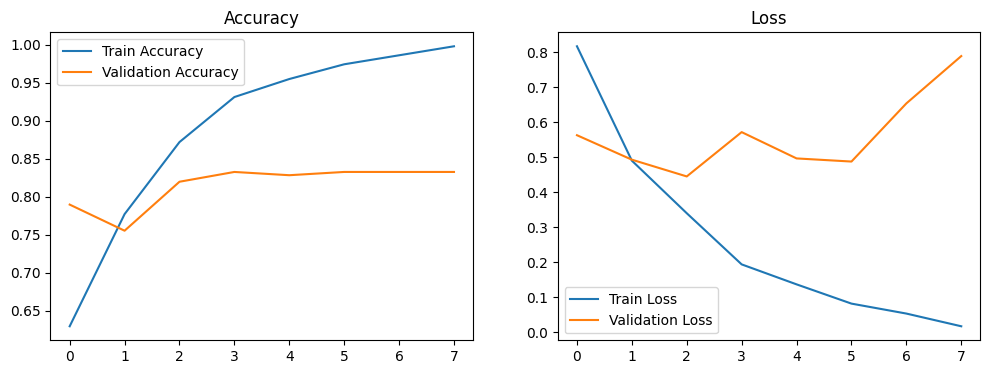

In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping


# ========================================================================
# 1. Tham số và Hằng số
# ========================================================================
IMG_SIZE = 224  # Giảm kích thước để tiết kiệm bộ nhớ
FRAMES_PER_VIDEO = 20
CHANNELS = 3
NUM_CLASSES = 2
BATCH_SIZE = 8  # 8
EPOCHS = 15  # 15

# ========================================================================
# 2. Tiền xử lý dữ liệu
# ========================================================================
def load_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < FRAMES_PER_VIDEO:
        ret, frame = cap.read()
        if not ret:
            break
        # Tiền xử lý frame: chuyển đổi màu và thay đổi kích thước
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frames.append(frame)
    cap.release()

    # Nếu video có số frame ít hơn yêu cầu, padding bằng ảnh đen
    while len(frames) < FRAMES_PER_VIDEO:
        frames.append(np.zeros((IMG_SIZE, IMG_SIZE, CHANNELS)))

    return np.array(frames) / 255.0  # Chuẩn hóa

def load_dataset(data_dir):
    video_paths = []
    labels = []

    for video_file in os.listdir(data_dir):
        if video_file.endswith('.mp4'):
            video_paths.append(os.path.join(data_dir, video_file))
            # Kiểm tra tên tệp để xác định nhãn: nếu chứa 'fi' thì là fight, ngược lại là no-fight
            if 'NV' in video_file:
                labels.append(0)  # 0: fight
            else:
                labels.append(1)  # 1: no-fight

    return video_paths, to_categorical(labels, num_classes=NUM_CLASSES)

# ========================================================================
# 3. Tạo Data Generator
# ========================================================================
class VideoDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_paths, labels, batch_size):
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.video_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_paths = self.video_paths[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_labels = self.labels[idx*self.batch_size : (idx+1)*self.batch_size]

        batch_videos = []
        for path in batch_paths:
            video = load_video_frames(path)
            batch_videos.append(video)

        return np.array(batch_videos), np.array(batch_labels)

# ========================================================================
# 4. Xây dựng mô hình 3D CNN
# ========================================================================
def build_3dcnn_model():
    model = Sequential([
        # Block 1
        Conv3D(32, (3, 3, 3), activation='relu',
               input_shape=(FRAMES_PER_VIDEO, IMG_SIZE, IMG_SIZE, CHANNELS)),
        MaxPooling3D((1, 2, 2)),

        # Block 2
        Conv3D(64, (3, 3, 3), activation='relu'),
        MaxPooling3D((1, 2, 2)),

        # Block 3
        Conv3D(128, (3, 3, 3), activation='relu'),
        MaxPooling3D((2, 2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# ========================================================================
# 5. Huấn luyện và Đánh giá
# ========================================================================
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

# ========================================================================
# 6. Thực thi chính
# ========================================================================
if __name__ == "__main__":
    # Load dataset
    data_dir = "/content/Dataset/DataSetCustom"  # Thay đổi đường dẫn
    video_paths, labels = load_dataset(data_dir)

    # Chia dữ liệu thành tập huấn luyện và tập kiểm tra
    X_train, X_val, y_train, y_val = train_test_split(
        video_paths, labels, test_size=0.2, stratify=labels, random_state=42
    )

    # Tạo generators
    train_generator = VideoDataGenerator(X_train, y_train, BATCH_SIZE)
    val_generator = VideoDataGenerator(X_val, y_val, BATCH_SIZE)

    # Xây dựng mô hình 3D CNN
    model = build_3dcnn_model()
    model.summary()



    early_stopping = EarlyStopping(
          monitor='val_loss',
          patience=5,
          restore_best_weights=True
      )


    # Huấn luyện mô hình
    history = model.fit(
          train_generator,
          validation_data=val_generator,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[early_stopping]
      )





    # Đánh giá và visualize kết quả
    plot_history(history)

    # Lưu mô hình theo định dạng Keras (.keras) thay vì .h5
    model.save("../models/V3.1dcnn_data2_224_20_e15_bath8.keras", save_format="keras")


###Train V4 3D CNN


In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# ========================================================================
# 1. Tham số và Hằng số
# ========================================================================
IMG_SIZE = 112
FRAMES_PER_VIDEO = 25
CHANNELS = 3
NUM_CLASSES = 2
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 1e-4
DROPOUT_RATE = 0.5  # Điều chỉnh dropout rate

# ========================================================================
# 2. Tiền xử lý dữ liệu
# ========================================================================
def load_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < FRAMES_PER_VIDEO:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frames.append(frame)
    cap.release()

    while len(frames) < FRAMES_PER_VIDEO:
        frames.append(np.zeros((IMG_SIZE, IMG_SIZE, CHANNELS)))

    return np.array(frames) / 255.0

def load_dataset(data_dir):
    video_paths = []
    labels = []

    for video_file in os.listdir(data_dir):
        if video_file.endswith('.mp4'):
            video_paths.append(os.path.join(data_dir, video_file))
            if 'NV' in video_file:
                labels.append(0)  # 0: no-violence
            else:
                labels.append(1)  # 1: violence

    return video_paths, to_categorical(labels, num_classes=NUM_CLASSES)

# ========================================================================
# 3. Tạo Data Generator (với Data Augmentation)
# ========================================================================
class VideoDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_paths, labels, batch_size, augment=False):
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.video_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_paths = self.video_paths[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_labels = self.labels[idx*self.batch_size : (idx+1)*self.batch_size]

        batch_videos = []
        for path in batch_paths:
            video = load_video_frames(path)
            if self.augment:
                video = self.augment_video(video)
            batch_videos.append(video)

        return np.array(batch_videos), np.array(batch_labels)

    def augment_video(self, video):
        for i in range(video.shape[0]):
            if np.random.random() < 0.5:
                video[i] = cv2.flip(video[i], 1)
            if np.random.random() < 0.3:
                video[i] = tf.image.random_brightness(video[i], max_delta=0.2)
        return video

# ========================================================================
# 4. Xây dựng mô hình 3D CNN (với BatchNormalization, L2 Regularization)
# ========================================================================
def build_3dcnn_model():
    model = Sequential([
        Conv3D(16, (3, 3, 3), activation='relu',
               input_shape=(FRAMES_PER_VIDEO, IMG_SIZE, IMG_SIZE, CHANNELS),
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling3D((1, 2, 2)),

        Conv3D(32, (3, 3, 3), activation='relu',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling3D((1, 2, 2)),

        Conv3D(64, (3, 3, 3), activation='relu',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling3D((2, 2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# ========================================================================
# 5. Huấn luyện và Đánh giá
# ========================================================================
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

# ========================================================================
# 6. Thực thi chính
# ========================================================================
if __name__ == "__main__":
    data_dir = "/content/Dataset/DataSetCustom"
    video_paths, labels = load_dataset(data_dir)

    X_train, X_val, y_train, y_val = train_test_split(
        video_paths, labels, test_size=0.2, stratify=labels, random_state=42
    )

    train_generator = VideoDataGenerator(X_train, y_train, BATCH_SIZE, augment=True)
    val_generator = VideoDataGenerator(X_val, y_val, BATCH_SIZE)

    model = build_3dcnn_model()
    model.summary()

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        verbose=1,
        callbacks=[early_stopping]
    )

    plot_history(history)

    model.save("/content/drive/MyDrive/Colab Notebooks/V4dcnn_data2_112_60_optimized.keras", save_format="keras")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 58, 110, 110, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 58, 110, 110, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 58, 55, 55, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 56, 53, 53, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 53, 53, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 56, 26, 26, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 54, 24, 24, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 54, 24, 24, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 27, 12, 12, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 248832)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      31,850,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,921,858 (121.77 MB)

 Trainable params: 31,921,634 (121.77 MB)

 Non-trainable params: 224 (896.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
45/59 ━━━━━━━━━━━━━━━━━━━━ 14:10 61s/step - accuracy: 0.4911 - loss: 13.5062

KeyboardInterrupt: 

In [ ]:
## v4.1 cnn

In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# ========================================================================
# 1. Tham số và Hằng số
# ========================================================================
IMG_SIZE = 112
FRAMES_PER_VIDEO = 60
CHANNELS = 3
NUM_CLASSES = 2
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 1e-4
DROPOUT_RATE = 0.5  # Điều chỉnh dropout rate

# ========================================================================
# 2. Tiền xử lý dữ liệu
# ========================================================================
def load_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < FRAMES_PER_VIDEO:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frames.append(frame)
    cap.release()

    while len(frames) < FRAMES_PER_VIDEO:
        frames.append(np.zeros((IMG_SIZE, IMG_SIZE, CHANNELS)))

    return np.array(frames) / 255.0

def load_dataset(data_dir):
    video_paths = []
    labels = []

    for video_file in os.listdir(data_dir):
        if video_file.endswith('.mp4'):
            video_paths.append(os.path.join(data_dir, video_file))
            if 'NV' in video_file:
                labels.append(0)  # 0: no-violence
            else:
                labels.append(1)  # 1: violence

    return video_paths, to_categorical(labels, num_classes=NUM_CLASSES)

# ========================================================================
# 3. Tạo Data Generator (với Data Augmentation)
# ========================================================================
class VideoDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_paths, labels, batch_size, augment=False):
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.video_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_paths = self.video_paths[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_labels = self.labels[idx*self.batch_size : (idx+1)*self.batch_size]

        batch_videos = []
        for path in batch_paths:
            video = load_video_frames(path)
            if self.augment:
                video = self.augment_video(video)
            batch_videos.append(video)

        return np.array(batch_videos), np.array(batch_labels)

    def augment_video(self, video):
        for i in range(video.shape[0]):
            if np.random.random() < 0.5:
                video[i] = cv2.flip(video[i], 1)
            if np.random.random() < 0.3:
                video[i] = tf.image.random_brightness(video[i], max_delta=0.2)
        return video

# ========================================================================
# 4. Xây dựng mô hình 3D CNN (với BatchNormalization, L2 Regularization)
# ========================================================================
def build_3dcnn_model():
    model = Sequential([
        Conv3D(16, (3, 3, 3), activation='relu',
               input_shape=(FRAMES_PER_VIDEO, IMG_SIZE, IMG_SIZE, CHANNELS),
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling3D((1, 2, 2)),

        Conv3D(32, (3, 3, 3), activation='relu',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling3D((1, 2, 2)),

        Conv3D(64, (3, 3, 3), activation='relu',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling3D((2, 2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# ========================================================================
# 5. Huấn luyện và Đánh giá
# ========================================================================
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

# ========================================================================
# 6. Thực thi chính
# ========================================================================
if __name__ == "__main__":
    data_dir = "/content/drive/MyDrive/Colab Notebooks/DataSetCustom"
    video_paths, labels = load_dataset(data_dir)

    X_train, X_val, y_train, y_val = train_test_split(
        video_paths, labels, test_size=0.2, stratify=labels, random_state=42
    )

    train_generator = VideoDataGenerator(X_train, y_train, BATCH_SIZE, augment=True)
    val_generator = VideoDataGenerator(X_val, y_val, BATCH_SIZE)

    model = build_3dcnn_model()
    model.summary()

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True
    )

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        verbose=1,
        callbacks=[early_stopping]
    )

    plot_history(history)

    model.save("/content/drive/MyDrive/Colab Notebooks/V3dcnn_data2_112_60_optimized.keras", save_format="keras")

#Use

##Use models img




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


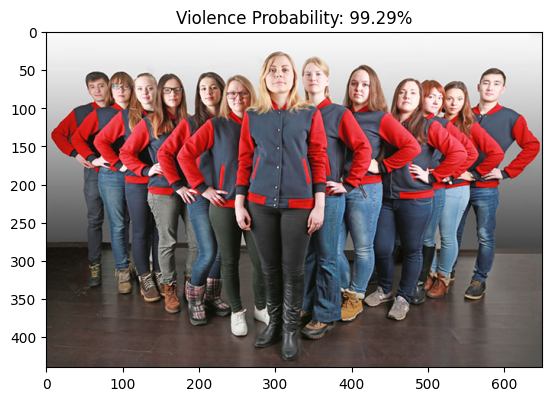

The image likely depicts violence.


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Load the pre-trained models
model = load_model("/content/drive/MyDrive/Colab Notebooks/Act_Model/fight.keras")  # Replace with your model path
image_model = VGG16(include_top=True, weights='imagenet')

# Get the transfer layer from VGG16
transfer_layer = image_model.get_layer('fc2')
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

# Define image size (must match the model's input size)
img_size = 224
img_size_touple = (img_size, img_size)
_images_per_file = 20


# Function to preprocess a single image and extract transfer values
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size_touple)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Extract transfer values using VGG16
    transfer_values = image_model_transfer.predict(img)
    return transfer_values


def predict_violence(image_path):
    # Preprocess the image and get transfer values
    transfer_values = preprocess_image(image_path)
    if transfer_values is None:
        return

    # Create dummy input sequence for the model using transfer values
    dummy_sequence = np.repeat(transfer_values, _images_per_file, axis=0)
    dummy_sequence = np.expand_dims(dummy_sequence, axis=0)  # Add another dimension for LSTM

    # Make prediction
    prediction = model.predict(dummy_sequence)
    violence_probability = prediction[0][0]

    # Display the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Violence Probability: {violence_probability * 100:.2f}%")
    plt.show()

    if violence_probability > 0.5:
        print("The image likely depicts violence.")
    else:
        print("The image likely does not depict violence.")


# Example usage
image_path = "/content/dong.jpg"  # Replace with your actual image path
predict_violence(image_path)

##Ues Video 3D CNN


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
Overall Violence Probability for the video: 10.74%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Frame 1: Violence Probability = 10.98%


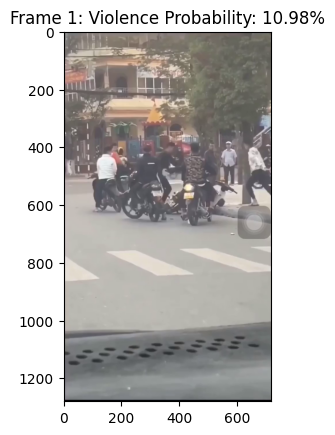

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Frame 2: Violence Probability = 11.11%


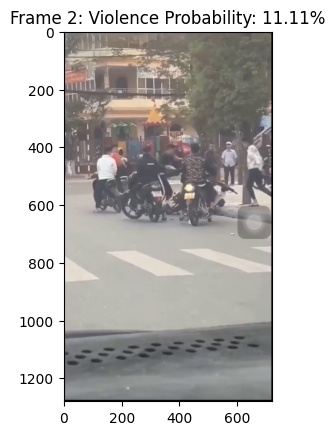

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Frame 3: Violence Probability = 11.17%


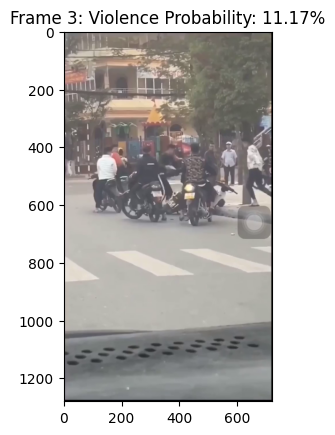

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Frame 4: Violence Probability = 10.65%


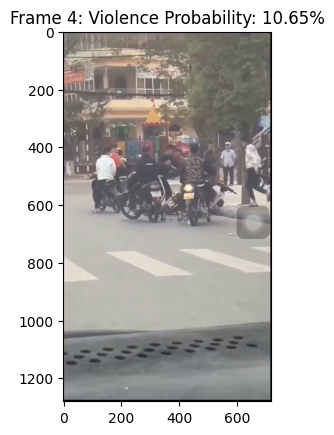

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Frame 5: Violence Probability = 10.67%


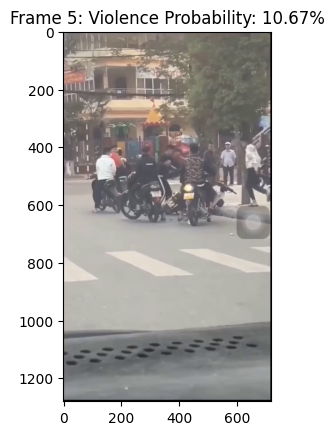

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Frame 6: Violence Probability = 10.72%


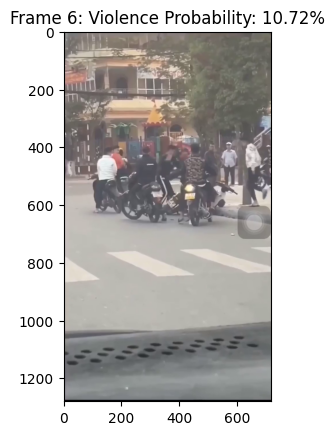

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Frame 7: Violence Probability = 10.73%


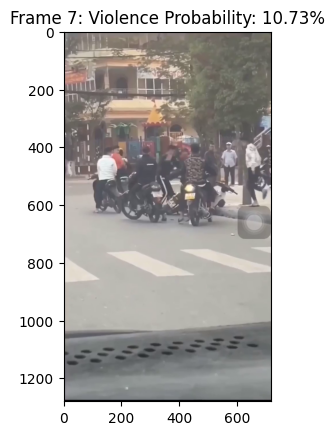

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Frame 8: Violence Probability = 11.15%


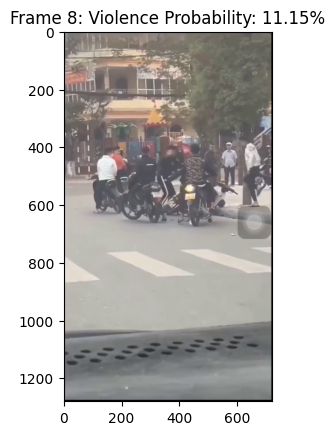

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Frame 9: Violence Probability = 11.13%


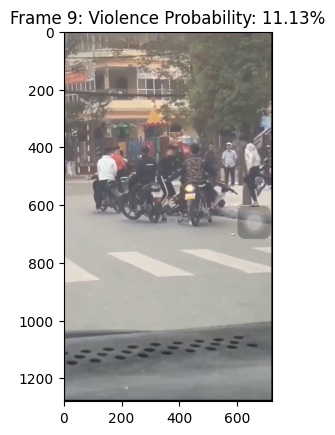

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Frame 10: Violence Probability = 11.19%


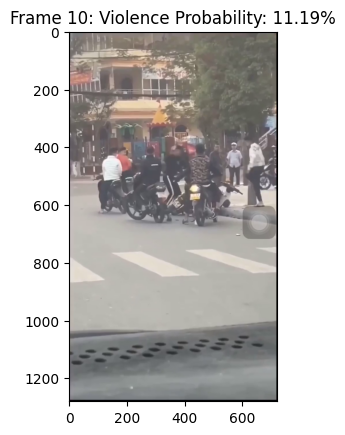

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the pre-trained model
model = load_model("/content/drive/MyDrive/Colab Notebooks/Act_Model/fight_3dcnn.keras")

# Define image size and frames per file (match model input)
img_size = 112  # Update img_size to match your model's input size
_images_per_file = 10  # Update frames per file to match the model's input


def preprocess_frame(frame):
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))  # Resize to match model input
    img = img / 255.0  # Normalize pixel values
    # Reshape to add an extra channel dimension for grayscale conversion
    img = img.astype(np.float32)  # Convert the image to float32 type
    img = np.expand_dims(img, axis=0)

    return img


def predict_violence_video(video_path):
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    frames = []
    frame_sequence = []  # Store frames for the sequence

    while success and len(frames) < _images_per_file:
        frames.append(image)
        processed_frame = preprocess_frame(image)  # Extract transfer values
        frame_sequence.append(processed_frame)
        success, image = vidcap.read()

    if not frames:
        print(f"Error: No frames could be read from {video_path}.")
        return

    # Pad with the last frame if fewer than _images_per_file frames
    while len(frame_sequence) < _images_per_file:
        frame_sequence.append(frame_sequence[-1])

    # Prepare input for the 3D CNN model
    input_sequence = np.concatenate(frame_sequence, axis=0)  # Shape: (_images_per_file, img_size, img_size, 3)
    input_sequence = np.expand_dims(input_sequence, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(input_sequence)
    violence_probability = prediction[0][0]  # Get violence probability

    print(f"Overall Violence Probability for the video: {violence_probability * 100:.2f}%")

    # Process each frame and print individual violence probabilities
    for i, frame in enumerate(frames):
        # Use preprocessed frames from frame_sequence
        frame_data = frame_sequence[i]
        # Create dummy sequence with repeated frame if needed
        dummy_sequence = np.repeat(frame_data, _images_per_file, axis=0)
        dummy_sequence = np.expand_dims(dummy_sequence, axis=0)

        frame_prediction = model.predict(dummy_sequence)
        frame_violence_prob = frame_prediction[0][0]

        print(f"Frame {i + 1}: Violence Probability = {frame_violence_prob * 100:.2f}%")

        # Display the frame with its violence probability
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"Frame {i + 1}: Violence Probability: {frame_violence_prob * 100:.2f}%")
        plt.show()


# Example usage with a video
video_path = "/content/5782959150257267889.mp4"  # Replace with the actual video path
predict_violence_video(video_path)